# Modelos Probabilísticos de Difusión de Eliminación de Ruido (DDPMs) con el conjunto de datos MedNIST

En el presente notebook se muestra cómo entrenar un modelo de difusión DDPM para crear imágenes sintéticas 2D usando el código del proyecto [MONAI][https://github.com/Project-MONAI/GenerativeModels]. El modelo DDPM se basa en el artículo de investigación de Ho et al. [1].

[1] - Ho et al. "Denoising Diffusion Probabilistic Models" https://arxiv.org/abs/2006.11239

## Importar librerías necesarias

In [1]:
import os
import shutil
import tempfile
import time
from itertools import combinations

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms

from monai.apps import MedNISTDataset
from monai.config import print_config
from monai.utils import first, set_determinism
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

import torch.optim.lr_scheduler as lr_scheduler

from generative.metrics import FIDMetric, MultiScaleSSIMMetric, SSIMMetric

from generative.inferers import DiffusionInferer
from generative.networks.nets import DiffusionModelUNet
from generative.networks.schedulers import DDPMScheduler

print_config()

MONAI version: 1.3.2
Numpy version: 1.26.4
Pytorch version: 2.3.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 59a7211070538586369afd4a01eca0a7fe2e742e
MONAI __file__: /opt/anaconda3/envs/tfm/lib/python3.12/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: 1.13.1
Pillow version: 10.3.0
Tensorboard version: 2.6.0
gdown version: 5.2.0
TorchVision version: 0.18.1
tqdm version: 4.66.4
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 2.2.2
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN 

## Elegir un directorio de almacenamiento de datos

Elegir un directorio de almacenamiento de datos para guardar los datos descargados y los modelos entrenados. Si no se especifica, se utilizará un directorio temporal que se eliminará después de la ejecución.

In [15]:
directory = '/Users/alzorrcarri'
# directory = r"D:\MONAI_DATA_DIRECTORY"
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/Users/alzorrcarri


## Preparar el conjunto de datos MedNIST y los dataloaders de entrenamiento y validación

En este tutorial, entrenaremos nuestros modelos en el conjunto de datos MedNIST disponible en MONAI (https://docs.monai.io/en/stable/apps.html#monai.apps.MedNISTDataset). Para entrenar más rápido, seleccionaremos solo una de las clases disponibles ("Hand"), lo que resulta en un conjunto de entrenamiento con 7999 imágenes 2D.

In [3]:
train_data = MedNISTDataset(root_dir=root_dir, section="training", download=True, progress=False, seed=0)
train_datalist = [{"image": item["image"]} for item in train_data.data if item["class_name"] == "Hand"]

2024-07-03 21:28:42,218 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2024-07-03 21:28:42,218 - INFO - File exists: /Users/alzorrcarri/MedNIST.tar.gz, skipped downloading.
2024-07-03 21:28:42,219 - INFO - Non-empty folder exists in /Users/alzorrcarri/MedNIST, skipped extracting.


In [16]:
val_data = MedNISTDataset(root_dir=root_dir, section="validation", download=True, progress=False, seed=0)
val_datalist = [{"image": item["image"]} for item in val_data.data if item["class_name"] == "Hand"]

2024-07-03 21:58:10,157 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2024-07-03 21:58:10,157 - INFO - File exists: /Users/alzorrcarri/MedNIST.tar.gz, skipped downloading.
2024-07-03 21:58:10,158 - INFO - Non-empty folder exists in /Users/alzorrcarri/MedNIST, skipped extracting.


In [17]:
transformations = transforms.Compose([
    transforms.CenterCrop(45),
    transforms.Resize(32),
    transforms.Normalize(mean=0.0, std=255.0),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomInvert(p=0.25)
])

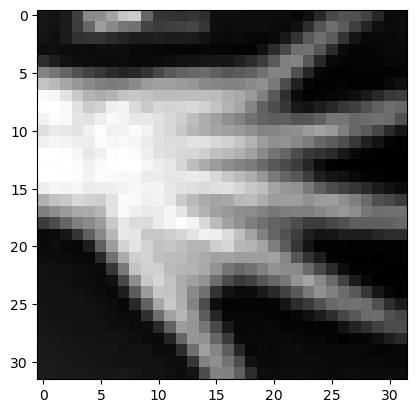

In [6]:
train_images = []
for i in range(len(train_datalist)):
    image = plt.imread(train_datalist[i]['image'])
    image = torch.tensor(image, dtype=torch.float32)
    image = image.unsqueeze(0)
    image = transformations(image) 
    train_images.append(image)

plt.imshow(train_images[0].permute(2, 1, 0), cmap='gray')

In [7]:
train_images = torch.stack(train_images)

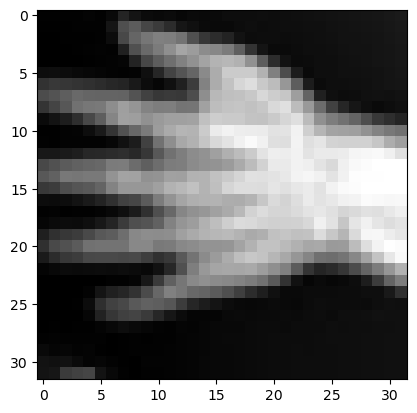

In [18]:
val_images = []
for i in range(len(val_datalist)): 
    image = plt.imread(val_datalist[i]['image'])
    image = torch.tensor(image, dtype=torch.float32)
    image = image.unsqueeze(0)
    image = transformations(image) 
    val_images.append(image)

plt.imshow(val_images[0].permute(2, 1, 0), cmap='gray')

In [19]:
val_images = torch.stack(val_images)

In [10]:
train_loader = DataLoader(train_images, batch_size=32, shuffle=True, num_workers=2, persistent_workers=True)

In [20]:
val_loader = DataLoader(val_images, batch_size=32, shuffle=False, num_workers=2, persistent_workers=True)

### Visualización de las imágenes de entrenamiento

forma del batch: torch.Size([32, 1, 32, 32])


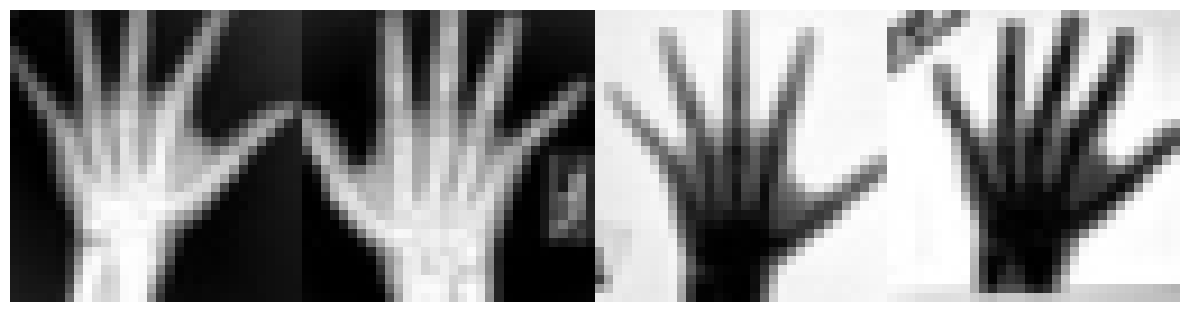

In [11]:
check_data = first(train_loader)
print(f"forma del batch: {check_data.shape}")
image_visualisation = torch.cat(
    [check_data[0, 0], check_data[1, 0], check_data[2, 0], check_data[3, 0]], dim=1
)
plt.figure("training images", (12, 6))
plt.imshow(image_visualisation, vmin=0, vmax=1, cmap="gray")
plt.axis("off")
plt.tight_layout()
plt.show()

In [12]:
# Guardamos varias de las imágenes de entrenamiento en disco
for i in range(len(check_data)):
    plt.imsave(f"/Users/alzorrcarri/Library/CloudStorage/Dropbox/tfm/codigo/MONAI Project/DDPM2D MedNIST Hand MONAI/train_{i}.png", check_data[i, 0], cmap="gray")

### Definición de la red, programador, optimizador e inferer
En este paso, instanciamos los componentes de MONAI para crear un DDPM, el UNET, el programador de ruido y el inferer utilizados para el entrenamiento y el muestreo. Estamos utilizando el programador de ruido DDPM original que contiene 1000 pasos de tiempo en su cadena de Markov, y un UNET 2D con mecanismos de atención en el 2º y 3er niveles, cada uno con 1 cabeza de atención.

In [2]:
device = torch.device("mps")

model = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    num_channels=(128, 256, 256),
    attention_levels=(False, True, True),
    num_res_blocks=1,
    num_head_channels=256,
)
model.to(device)

scheduler = DDPMScheduler(num_train_timesteps=1000)

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

inferer = DiffusionInferer(scheduler)

## Entrenamiento del modelo

Entrenamos el modelo DDPM con el conjunto de datos MedNIST. Durante el entrenamiento se estudia la evolución y el valor final de la función de pérdida y el FID en función de la tasa de aprendizaje (valor y evolución), el número de timesteps para el DDPMScheduler o el número de epochs de entrenamiento del modelo.

Epoch 0:   0%|                                | 0/250 [00:00<?, ?it/s]/opt/anaconda3/envs/tfm/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
100%|██████████| 1000/1000 [00:21<00:00, 46.05it/s]


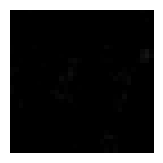

100%|██████████| 1000/1000 [00:20<00:00, 47.73it/s]


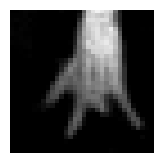

100%|██████████| 1000/1000 [00:20<00:00, 47.76it/s]


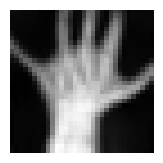

100%|██████████| 1000/1000 [00:20<00:00, 47.87it/s]


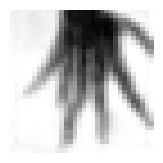

100%|██████████| 1000/1000 [00:21<00:00, 47.33it/s]


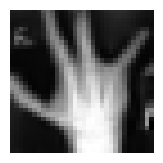

100%|██████████| 1000/1000 [02:50<00:00,  5.87it/s] 


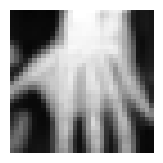

100%|██████████| 1000/1000 [00:20<00:00, 47.66it/s]


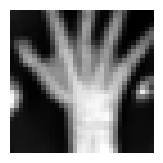

100%|██████████| 1000/1000 [00:21<00:00, 47.23it/s]


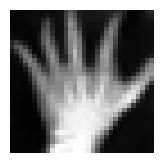

100%|██████████| 1000/1000 [00:20<00:00, 47.63it/s]


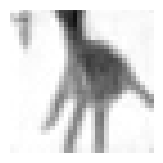

100%|██████████| 1000/1000 [00:20<00:00, 48.01it/s]


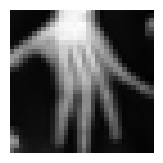

100%|██████████| 1000/1000 [00:21<00:00, 47.29it/s]


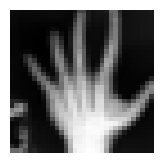

100%|██████████| 1000/1000 [00:21<00:00, 47.30it/s]


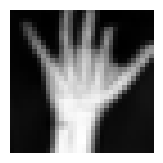

100%|██████████| 1000/1000 [00:21<00:00, 47.42it/s]


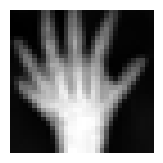

100%|██████████| 1000/1000 [00:20<00:00, 47.90it/s]


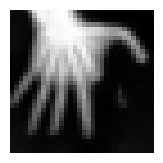

Entrenamiento completado, total time: 8072.275612831116.


In [15]:
n_epochs = 70
val_interval = 5 # Intervalo de épocas para calcular la pérdida respecto al conjunto de validación
epoch_loss_list = [] # Para almacenar los valores de la función de pérdida en cada época
val_epoch_loss_list = []

# Definimos los distintos tipos de schedulers que podemos utilizar
lr_sch = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.2, total_iters=n_epochs)
lr_value_list = []

scaler = GradScaler()
total_start = time.time()

# Entrenamiento del modelo
for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch.to(device)
        optimizer.zero_grad(set_to_none=True)
        with autocast(enabled=True):
            noise = torch.randn_like(images).to(device)
            timesteps = torch.randint(
                0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
            ).long()
            noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)
            loss = F.mse_loss(noise_pred.float(), noise.float())
        scaler.scale(loss).backward()
        scaler.step(optimizer) # Actualizamos los pesos del modelo
        scaler.update()
        epoch_loss += loss.item()
        progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})
    epoch_loss_list.append(epoch_loss / (step + 1))
    lr_value_list.append(lr_sch.get_last_lr()[0])
    lr_sch.step() # Actualizamos el learning rate

    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_epoch_loss = 0
        for step, batch in enumerate(val_loader):
            images = batch.to(device)
            with torch.no_grad():
                with autocast(enabled=True):
                    noise = torch.randn_like(images).to(device)
                    timesteps = torch.randint(
                        0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
                    ).long()
                    noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)
                    val_loss = F.mse_loss(noise_pred.float(), noise.float())
            val_epoch_loss += val_loss.item()
            progress_bar.set_postfix({"val_loss": val_epoch_loss / (step + 1)})
        val_epoch_loss_list.append(val_epoch_loss / (step + 1))

        # Generamos una imagen durante el entrenamiento para observar la mejora de la calidad de las imágenes generadas
        noise = torch.randn((1, 1, 32, 32))
        noise = noise.to(device)
        scheduler.set_timesteps(num_inference_steps=1000)
        with autocast(enabled=True):
            syn_images = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=scheduler)
        # Ploteamos una de las imágenes generadas
        plt.figure(figsize=(2, 2))
        plt.imshow(syn_images[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
        plt.tight_layout()
        plt.axis("off")
        plt.savefig(os.path.join("/Users/alzorrcarri/Library/CloudStorage/Dropbox/tfm/codigo/MONAI Project/DDPM2D MedNIST Hand MONAI/training_sampling", f"synthetic_image_{epoch}.png"))
        plt.show()

total_time = time.time() - total_start
print(f"Entrenamiento completado, total time: {total_time}.")

Guardamos el modelo entrenado en el directorio de almacenamiento de datos especificado anteriormente.

In [16]:
torch.save(model.state_dict(), "/Users/alzorrcarri/Library/CloudStorage/Dropbox/tfm/codigo/MONAI Project/DDPM2D MedNIST Hand MONAI/ddpm2d_hand_model.pt")

In [17]:
# Guardamos en un fichero csv los valores de la función de pérdida y del FID para cada epoch.
import csv

with open("/Users/alzorrcarri/Library/CloudStorage/Dropbox/tfm/codigo/MONAI Project/DDPM2D MedNIST Hand MONAI/ddpm2d_hand_model_numeric_results.csv", mode="w") as file:
    writer = csv.writer(file)
    writer.writerow(["Epoch", "Train Loss", "Validation Loss", "Learning Rate"])
    i = 0
    for epoch in range(n_epochs):
        if (epoch+1) % val_interval == 0:
            writer.writerow([epoch, epoch_loss_list[epoch], val_epoch_loss_list[i], lr_value_list[epoch]])
            i += 1
        else:
            writer.writerow([epoch, epoch_loss_list[epoch], "", lr_value_list[epoch]])

### Graficando el proceso de muestreo a lo largo de la cadena de Markov de DDPM

In [ ]:
model.eval()
noise = torch.randn((1, 1, 32, 32))
noise = noise.to(device)
scheduler.set_timesteps(num_inference_steps=1000)
with autocast(enabled=True):
    image, intermediates = inferer.sample(
        input_noise=noise, diffusion_model=model, scheduler=scheduler, save_intermediates=True, intermediate_steps=100
    )

chain = torch.cat(intermediates, dim=-1)

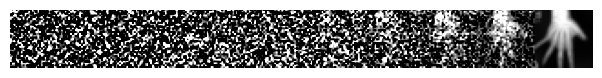

In [21]:
plt.style.use("default")
plt.imshow(chain[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.savefig("/Users/alzorrcarri/Library/CloudStorage/Dropbox/tfm/codigo/MONAI Project/DDPM2D MedNIST Hand MONAI/synthetic_image_chain.png", dpi=300)
plt.show()

### Calculando el SSIM para un conjunto de imágenes sintéticas

Calculamos el SSIM y el MS-SSIM entre pares de imágenes sintéticas, los resultados del MS-SSIM y SSIM se pueden utilizar para evaluar la diversidad de las muestras sintéticas.

In [3]:
model.load_state_dict(torch.load("/Users/alzorrcarri/Library/CloudStorage/Dropbox/tfm/codigo/MONAI Project/DDPM2D MedNIST Hand MONAI/ddpm2d_hand_model.pt", map_location=device))

<All keys matched successfully>

In [4]:
ms_ssim = MultiScaleSSIMMetric(spatial_dims=2, data_range=1.0, kernel_size=2)
ssim = SSIMMetric(spatial_dims=2, data_range=1.0, kernel_size=2)

In [5]:
n_synthetic_images = 100 # Número de imágenes sintéticas que vamos a generar

model.eval()
noise = torch.randn((n_synthetic_images, 1, 32, 32))
noise = noise.to(device)
scheduler.set_timesteps(num_inference_steps=1000)
with torch.no_grad():
    syn_images = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=scheduler)

100%|██████████| 1000/1000 [05:00<00:00,  3.33it/s]


In [6]:
# Guardamos las imágenes generadas en disco
for i in range(n_synthetic_images):
    plt.imsave(f"/Users/alzorrcarri/Library/CloudStorage/Dropbox/tfm/codigo/MONAI Project/DDPM2D MedNIST Hand MONAI/metrics_images/synthetic_image_{i}.png", syn_images[i, 0].cpu(), cmap="gray")

In [10]:
ms_ssim_scores = [] # Para almacenar los valores de MS-SSIM y SSIM entre las imágenes generadas
ssim_scores = []
# Se calculan las métricas de calidad entre todas las combinaciones posibles de pares de imágenes generadas
idx_pairs = list(combinations(range(n_synthetic_images), 2))
for idx_a, idx_b in idx_pairs:
    ms_ssim_scores.append(ms_ssim(syn_images[[idx_a]], syn_images[[idx_b]]))
    ssim_scores.append(ssim(syn_images[[idx_a]], syn_images[[idx_b]]))

In [11]:
ms_ssim_scores = torch.cat(ms_ssim_scores, dim=0)
ssim_scores = torch.cat(ssim_scores, dim=0)

# Mostramos la media y la desviación estándar de los valores de MS-SSIM y SSIM
print(f"MS-SSIM Metric: {ms_ssim_scores.mean():.4f} +- {ms_ssim_scores.std():.4f}")
print(f"SSIM Metric: {ssim_scores.mean():.4f} +- {ssim_scores.std():.4f}")

MS-SSIM Metric: 0.1784 +- 0.2409
SSIM Metric: 0.1654 +- 0.1078


In [34]:
# Si quitamos las imágenes con fondo de color blanco, ¿mejora el SSIM y el Ms-SSIM? Comprobémoslo
syn_images_no_bg = []
for i in range(n_synthetic_images):
    if syn_images[i, 0, 0, 31] <= 0.5:
        syn_images_no_bg.append(syn_images[i])
syn_images_no_bg = torch.stack(syn_images_no_bg)

ms_ssim_scores_no_bg = [] # Para almacenar los valores de MS-SSIM y SSIM entre las imágenes generadas sin fondo blanco
ssim_scores_no_bg = []
# Se calculan las métricas de calidad entre todas las combinaciones posibles de pares de imágenes generadas sin fondo blanco
idx_pairs = list(combinations(range(len(syn_images_no_bg)), 2))
for idx_a, idx_b in idx_pairs:
    ms_ssim_scores_no_bg.append(ms_ssim(syn_images_no_bg[[idx_a]], syn_images_no_bg[[idx_b]]))
    ssim_scores_no_bg.append(ssim(syn_images_no_bg[[idx_a]], syn_images_no_bg[[idx_b]]))

ms_ssim_scores_no_bg = torch.cat(ms_ssim_scores_no_bg, dim=0)
ssim_scores_no_bg = torch.cat(ssim_scores_no_bg, dim=0)

# Mostramos la media y la desviación estándar de los valores de MS-SSIM y SSIM sin fondo blanco
print(f"MS-SSIM Metric (no bg): {ms_ssim_scores_no_bg.mean():.4f} +- {ms_ssim_scores_no_bg.std():.4f}")
print(f"SSIM Metric (no bg): {ssim_scores_no_bg.mean():.4f} +- {ssim_scores_no_bg.std():.4f}")



MS-SSIM Metric (no bg): 0.2345 +- 0.2510
SSIM Metric (no bg): 0.2049 +- 0.0836


## Calculando el FID para las imágenes generadas

### Carga de ResNet50 entrenado con RadImageNwt

A la hora de calcular la métrica FID (Frechet Inception Distance) para evaluar la calidad de las imágenes generadas, necesitamos un modelo de clasificación de imágenes preentrenado. En este tutorial, utilizamos una ResNet50 preentrenada con el conjunto de datos RadImageNet. La ResNet50 se descarga del repositorio de GitHub https://github.com/Warvito/radimagenet-models/tree/main.

In [12]:
device = torch.device("mps")
radnet = torch.hub.load("Warvito/radimagenet-models", model="radimagenet_resnet50", verbose=True)
radnet.to(device)
radnet.eval()

Using cache found in /Users/alzorrcarri/.cache/torch/hub/Warvito_radimagenet-models_main


ResNet50(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1.001e-05, momentum=0.01, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1.001e-05, momentum=0.99, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1.001e-05, momentum=0.99, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(256, eps=1.001e-05, momentum=0.99, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm

Las transformaciones que se definen a continuación son necesarias para transformar las imágenes de entrada de la misma manera que las imágenes se procesaron para el entrenamiento de RadImageNet. Defimos la función get_features que aplica dichas transformaciones y extrae las características de las imágenes de entrada utilizando la ResNet50 preentrenada.

In [13]:
def subtract_mean(x: torch.Tensor) -> torch.Tensor:
    mean = [0.406, 0.456, 0.485]
    x[:, 0, :, :] -= mean[0]
    x[:, 1, :, :] -= mean[1]
    x[:, 2, :, :] -= mean[2]
    return x


def spatial_average(x: torch.Tensor, keepdim: bool = True) -> torch.Tensor:
    return x.mean([2, 3], keepdim=keepdim)


def get_features(image):
    # Si el input tiene solo un canal, repetirlo hasta que se tengan tres canales
    if image.shape[1]:
        image = image.repeat(1, 3, 1, 1)

    # Cambiar el orden de 'RGB' a 'BGR'
    image = image[:, [2, 1, 0], ...]

    # Restar la media usada durante el entrenamiento
    image = subtract_mean(image)

    # Obtener las salidas del modelo
    with torch.no_grad():
        feature_image = radnet.forward(image)
        # Aplanar la imagen espacialmente
        feature_image = spatial_average(feature_image, keepdim=False)

    return feature_image

### Obtención media y covarianza distribución imágenes reales

Calculamos las características de la red ResNet50 para la distribución de las imágenes reales (imágenes de validación) para poder calcular el FID con las imágenes sampleadas durante el entrenamiento.

In [21]:
real_features = []
for _, batch in enumerate(val_loader):
    real_images = batch.to(device)
    real_features.append(get_features(real_images))

real_features = torch.vstack(real_features)

Ídem para las imágenes generadas.

In [22]:
generated_features = get_features(syn_images)

Calculamos el FID usando la implementación de dicha métrica en el repositorio [GenerativeModels](https://github.com/Project-MONAI/GenerativeModels/tree/main) del Proyecto MONAI

In [23]:
fid = FIDMetric()
fid_score = fid(real_features.cpu(), generated_features.cpu())
print(f"FID Score: {fid_score:.4f}")

FID Score: 5.9603
